## Implementation of skip - gram model

Goal: to build a word embedding dictionary from the mutual fund prospectus in the training set

#### Load the data --> RAG results

In [183]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split


import os
path = os.getcwd()

In [184]:
csv_path = path + "/NLP_app/MutualFundLabelsPlusPredictions.csv"

In [185]:
df = pd.read_csv(csv_path)

df = df.dropna(subset=["Prediction"]).copy()
print(df.head())
df.shape


                     id                         fund_name Performance fee?  \
0  0000051931-18-000151  American Funds College 2018 Fund              NaN   
1  0000051931-18-000151  American Funds College 2021 Fund              NaN   
2  0000051931-18-000151  American Funds College 2024 Fund              NaN   
3  0000051931-18-000151  American Funds College 2027 Fund              NaN   
4  0000051931-18-000151  American Funds College 2030 Fund              NaN   

        Investment Strategy Derivatives_label        Portfolio composition  \
0  Balanced Fund (Low Risk)               Yes  Investment grade securities   
1  Balanced Fund (Low Risk)               Yes  Investment grade securities   
2  Balanced Fund (Low Risk)               Yes  Investment grade securities   
3  Balanced Fund (Low Risk)               Yes  Investment grade securities   
4  Balanced Fund (Low Risk)               Yes  Investment grade securities   

   Concentration                        Predicted Strategy  \


(461, 10)

#### first split the data into training, validation, and testing

In [186]:
# First split: 70% training, 30% temporary
df_training, df_temp = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Prediction"],
    random_state=1
)

# Second split: 15% validation, 15% test from the 30%
df_validation, df_testing = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["Prediction"],
    random_state=1
)


In [187]:
df_training.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_testing.reset_index(drop=True, inplace=True)

In [188]:
print("Training set size:", df_training.shape)
print("Validation set size:", df_validation.shape)
print("Test set size:", df_testing.shape)

Training set size: (322, 10)
Validation set size: (69, 10)
Test set size: (70, 10)


In [189]:
# X = features (summaries or evidence)
X_training = df_training["Strategy evidence"]
X_testing = df_testing["Strategy evidence"]
X_validation = df_validation["Strategy evidence"]
# y = labels (predicted strategy from RAG)
Y_training= df_training["Prediction"]
Y_testing = df_testing['Prediction']
Y_valisation = df_validation['Prediction']


In [190]:
X_training

0      Vanguard Russell 1000 Index Fund <head_breaker...
1      Principal Investment Strategies\n\nNormally in...
2      Fidelity Advisor Semiconductors Fund\n\n<head_...
3      The dynamic asset allocation strategy seeks to...
4      Variable Portfolio\n\nBlackRock Global Inflati...
                             ...                        
317    Principal investment strategies The fund will ...
318    The Subadvisor takes a "bottom-up" investment ...
319    Principal Investment Strategies\n\nMFS (Massac...
320    The fund invests the remainder of its assets i...
321                      Principal Investment Strategies
Name: Strategy evidence, Length: 322, dtype: object

### Skip Gram Model Implementation

In [191]:
# Install tensorflow 2 to the virtual environment.
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub

# Restart Runtime after installation !
# -> Runtime -> Restart Runtime...
# Rerun the cell when the runtime has restarted

In [192]:
# Import the libraries
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Christian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Christian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Christian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Util
Some useful functions. <br>
You don’t really need to understand them, these are utilities functions.


In [193]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

### Preprocess the texts
#### Normalize text to reduce inflectional forms

In [194]:
df['Strategy evidence'][1]

'American Funds College 2021 Fund <head_breaker>\n\nAmerican Funds College 2021 Fund\n\nInvestment objectives The fund will seek to achieve the following objectives to varying degrees: growth, income and preservation of capital, depending on the proximity to its target date. The target date is meant to roughly correspond to the year in which the fund beneficiary will start to withdraw funds to meet higher education expenses. The fund will increasingly emphasize income and preservation of capital by investing a greater portion of its assets in bond, equity-income and balanced funds as it approaches and passes its target date. In this way, the fund seeks to achieve an appropriate balance of total return and stability during different time periods.'

In [195]:
stop_words = set(list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])
for word in stop_words:
    
    if word in ["no", "not", "none", "never", "nobody", "nothing", "nowhere", "neither", "nor"]:
        if word in stop_words:  # Check if the word exists in the set before removing
            stop_words.remove(word)

In [196]:
# tokenizer removes the stop words the tokens with no letters, tokens with non letter characters, and tokens with less than 3 letters
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').replace("'", " ").replace("<head breaker>", " ").replace("\n\n", " ")
    word_tokens = word_tokenize(txt)
    
    filtered_sentence = [
        w for w in word_tokens 
        if w not in stop_words and w.isalpha() #and len(w) >= 3
    ]

    return filtered_sentence


In [197]:
X_training[1]

'Principal Investment Strategies\n\nNormally investing at least 80% of assets in securities of issuers in emerging markets (countries that have an emerging stock market as defined by MSCI, countries or markets with low- to middle-income economies as classified by the World Bank, and other countries or markets with similar emerging characteristics) and other investments that are tied economically to emerging markets. Normally investing primarily in common stocks. Investing in either "growth" stocks or "value" stocks or both. Allocating the fund\'s assets across emerging markets sectors, using different Fidelity managers. Allocating investments across different emerging market countries. Using fundamental analysis of factors such as each issuer\'s financial condition and industry position, as well as market and economic conditions, to select investments. Principal Investment Risks'

In [198]:
df["Prediction"].unique()

array(['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Equity Long Only (Low Risk)'], dtype=object)

In [199]:
text_words = np.concatenate([tokenizer(summary) for summary in X_training])

In [200]:
text_words

array(['Vanguard', 'Russell', 'Index', ..., 'Principal', 'Investment',
       'Strategies'], dtype='<U17')

In [201]:
print(len(text_words))

32332


### Process Skip-Gram model Input

In [202]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 3.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).


In [203]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [204]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [205]:
# we give a unique id to each words in our vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [206]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 499


In [207]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [208]:
print(data[:20])

[0, 303, 84, 6, 0, 303, 84, 6, 19, 88, 8, 6, 41, 5, 0, 1, 97, 2, 9, 0]


In [209]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [210]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [211]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy') ## changed from binary
    return encoder, autoencoder

In [212]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [213]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 499)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 499)            │        25,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,449 (197.07 KB)

 Trainable params: 50,449 (197.07 KB)

 Non-trainable params: 0 (0.00 B)

In [214]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit(
    x=batch_generator(batch_size, num_skips, skip_window, vocab_size),
    steps_per_epoch=ceil(len(data) / batch_size),
    epochs=num_epochs
)


Epoch 1/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9578
Epoch 2/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0694


### Encoder to vectorize

In [215]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [216]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [217]:
# We can save the word2vec dictionary to reuse it later.
import pickle

def save_word2vec(word2vec, filepath="word2vec.pkl"):
    with open(os.path.join(filepath), "wb") as f:
        pickle.dump(word2vec, f)

save_word2vec(word2vec, path + "NLP_app")

### Visualization

In [218]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [219]:
words_neighbors_1 = get_n_closer('expenses', 10, word2vec)
print('words close to expenses : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))

words close to expenses : expenses, other, within, Fidelity, takes, preservation, Capped, issuers, page, range
words close to derivatives : derivatives, volatility, investor, commissions, attempt, To, industry, Subadvisor, risk, compared


In [220]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(499, 50)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(499, 2)


In [221]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [222]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])

    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['expenses', 'derivatives'], 10, word2vec)

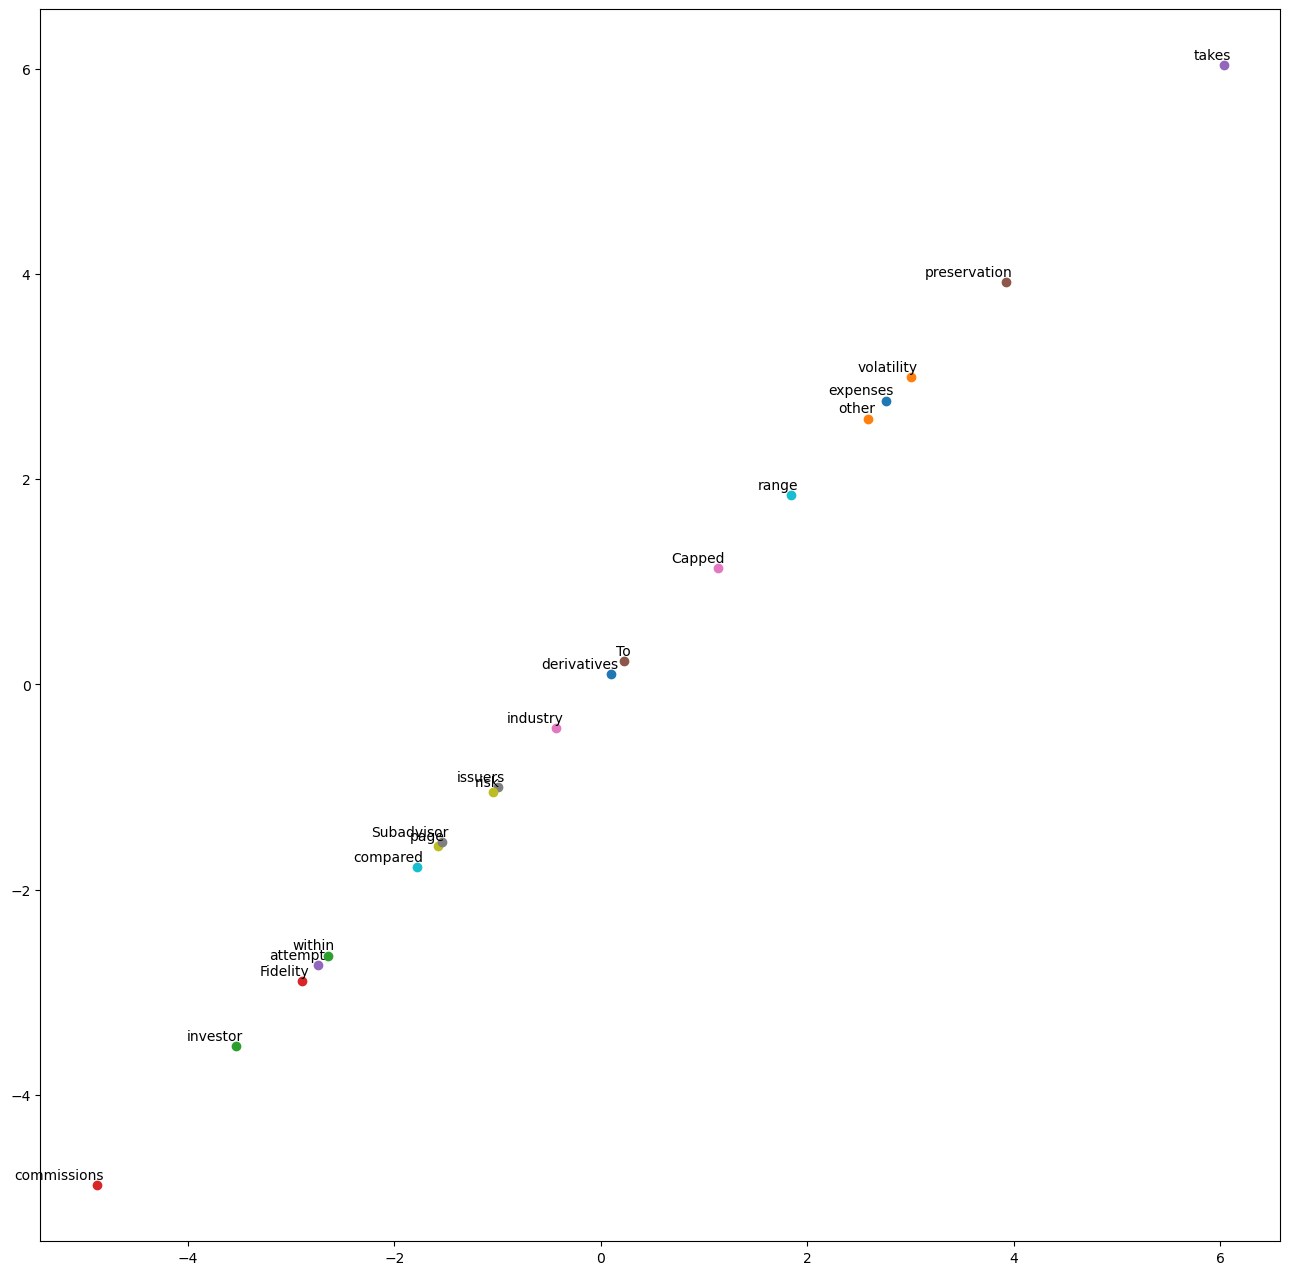

In [223]:
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

## Design a strategy to build knowledge bases of the three main mutual funds style

In [224]:
df_balanced = df_training[df_training["Prediction"] == "Balanced Fund (Low Risk)"]
df_fixed_income = df_training[df_training["Prediction"] == "Fixed Income Long Only (Low Risk)"]
df_equity = df_training[df_training["Prediction"] == "Equity Long Only (Low Risk)"]

In [225]:
df_equity.head()

,id,fund_name,Performance fee?,Investment Strategy,Derivatives_label,Portfolio composition,Concentration,Predicted Strategy,Strategy evidence,Prediction
0,0000932471-18-008471,Vanguard Russell 1000 Index Fund,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Category: Equity Long Only \nConfidence: 10,Vanguard Russell 1000 Index Fund <head_breaker...,Equity Long Only (Low Risk)
1,0001379491-18-006486,Fidelity Emerging Markets Fund,NaN,Equity Long Only (Low Risk),No,Sub-investment grade securities or emerging ma...,Diversified,Category: Equity Long Only \nConfidence: 9,Principal Investment Strategies\n\nNormally in...,Equity Long Only (Low Risk)
2,0001379491-18-003592,Fidelity Advisor Semiconductors Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Concentrated by issuer / sector / jurisdiction,Category: Equity Long Only \nConfidence: 9,Fidelity Advisor Semiconductors Fund\n\n<head_...,Equity Long Only (Low Risk)
5,0001193125-18-139001,Variable Portfolio - Oppenheimer International...,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 9,"In addition to investing in U.S. companies, th...",Equity Long Only (Low Risk)
15,0001193125-18-227777,Ivy Mid Cap Growth Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 10,Principal Investment Strategies\n\nIvy Mid Cap...,Equity Long Only (Low Risk)


In [226]:
from langchain.schema import Document

def create_docs(df_subset):
    return [
        Document(page_content=summary, metadata={"source": name})
        for summary, name in zip(df_subset["Strategy evidence"], df_subset["fund_name"])
    ]

docs_balanced = create_docs(df_balanced)
docs_fixed_income = create_docs(df_fixed_income)
docs_equity = create_docs(df_equity)


# Play with words?


In [227]:
# keywords got are based on common terminology
balanced_keywords = ['balance', 'mix', 'diversified', 'allocation']
fixed_income_keywords = ['bond', 'interest', 'credit', 'fixed', 'duration', 'maturity']
equity_keywords = ['equity', 'stock', 'shares', 'capital']


In [228]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [229]:
balanced_kb = create_knowledge_base(10, word2vec, balanced_keywords)
fixed_income_kb = create_knowledge_base(10, word2vec, fixed_income_keywords)
equity_kb = create_knowledge_base(10, word2vec, equity_keywords)


fixed not in word2vec
duration not in word2vec


## Scoring factor on validation data

objective is to score each sentence accordingly to their distance to the knowledge base.

#### We investigate different scoring/classifications on our validation set in order to pick the best for when we train

#### First strategy of scoring: counting the words in each category predicting the one with the most

In [230]:
def classify_summary_with_kb(text, tokenizer, balanced_kb, fixed_kb, equity_kb):
    tokens = tokenizer(text)

    score_balanced = sum(1 for t in tokens if t in balanced_kb)
    score_fixed = sum(1 for t in tokens if t in fixed_kb)
    score_equity = sum(1 for t in tokens if t in equity_kb)

    scores = {
        "Balanced Fund (Low Risk)": score_balanced,
        "Fixed Income Long Only (Low Risk)": score_fixed,
        "Equity Long Only (Low Risk)": score_equity
    }

    # Choose class with max score
    predicted_class = max(scores, key=scores.get)
    return predicted_class, scores


In [231]:
predictions = []
scores_list = []

for summary in df_validation["Strategy evidence"]:
    pred_class, score_dict = classify_summary_with_kb(summary, tokenizer, balanced_kb, fixed_income_kb, equity_kb)
    predictions.append(pred_class)
    scores_list.append(score_dict)

df_validation["KB_Predicted"] = predictions


In [232]:
print(df_validation["KB_Predicted"].isna().sum())
print(df_validation["KB_Predicted"].value_counts())


0
KB_Predicted
Fixed Income Long Only (Low Risk)    34
Equity Long Only (Low Risk)          22
Balanced Fund (Low Risk)             13
Name: count, dtype: int64


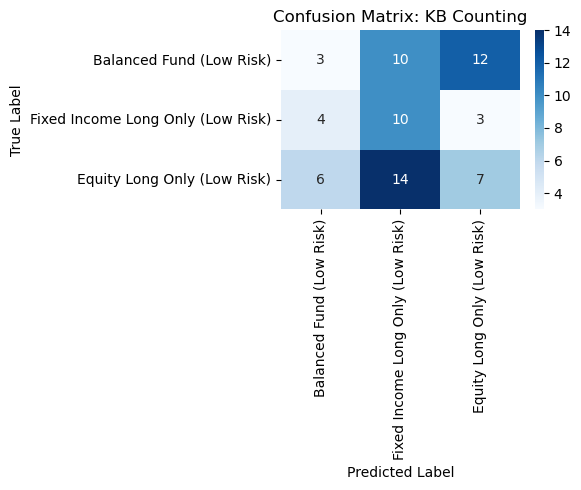

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.23      0.12      0.16        25
      Equity Long Only (Low Risk)       0.32      0.26      0.29        27
Fixed Income Long Only (Low Risk)       0.29      0.59      0.39        17

                         accuracy                           0.29        69
                        macro avg       0.28      0.32      0.28        69
                     weighted avg       0.28      0.29      0.27        69



In [233]:
strategy_labels = [
    "Balanced Fund (Low Risk)",
    "Fixed Income Long Only (Low Risk)",
    "Equity Long Only (Low Risk)"
]

cm = confusion_matrix(df_validation["Prediction"], df_validation["KB_Predicted"], labels=[
    "Balanced Fund (Low Risk)", "Fixed Income Long Only (Low Risk)", "Equity Long Only (Low Risk)"
])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=strategy_labels, yticklabels=strategy_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: KB Counting")
plt.tight_layout()
plt.show()


print(classification_report(df_validation["Prediction"], df_validation["KB_Predicted"]))

#### Second Strategy of Scoring: taking the difference between the barycenter of the sentence and the words in the knowledge base. We create the distance score by averaging the n_closer smaller distances

extract_sentence_distance is a Word embedding similarity (semantic proximity) method

In [234]:
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        
        # Compute the barycentre of the sentence
        for token in tokens:
            if token in word2vec:
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject:
            sentence_scores.append(1)  # Maximal score = worst fit
        else:
            sentence_barycentre = sentence_barycentre / effective_len

            # Only use words in the knowledge base that are also in word2vec
            valid_keywords = [key_word for key_word in knowledge if key_word in word2vec]

            if not valid_keywords:
                sentence_scores.append(1)  # No overlap at all
                continue

            barycentre_distance = [
                cosine(sentence_barycentre, word2vec[key_word])
                for key_word in valid_keywords
            ]

            barycentre_distance.sort()
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)

    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)


In [235]:
df_validation['KB_sentences_equity'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_distance(x, equity_kb, n_closer=10, n_reject=5, num_sent=5)
)
df_validation['KB_sentences_balanced'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_distance(x, balanced_kb, n_closer=10, n_reject=5, num_sent=5)
)

df_validation['KB_sentences_fixed_income'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_distance(x, fixed_income_kb, n_closer=10, n_reject=5, num_sent=5)
)



In [236]:
df_validation

,id,fund_name,Performance fee?,Investment Strategy,Derivatives_label,Portfolio composition,Concentration,Predicted Strategy,Strategy evidence,Prediction,KB_Predicted,KB_sentences_equity,KB_sentences_balanced,KB_sentences_fixed_income
0,0001193125-18-227777,Ivy Micro Cap Growth Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 9,Principal Investment Strategies\n\nIvy Micro C...,Equity Long Only (Low Risk),Equity Long Only (Low Risk),Principal Investment Strategies\n\nIvy Micro C...,"The Fund primarily invests in common stock, wh...","The Fund primarily invests in common stock, wh..."
1,0001683863-18-000108,Total Return Strategy Fund,Some performance Fees,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,Category: Fixed Income Long Only \nConfidence: 9,PRINCIPAL INVESTMENT STRATEGIES The fund selec...,Fixed Income Long Only (Low Risk),Fixed Income Long Only (Low Risk),The fund is managed using a benchmark unconstr...,The fund is managed using a benchmark unconstr...,The fund is managed using a benchmark unconstr...
2,0000051931-18-000465,Ultra-Short Bond Fund,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Category: Fixed Income Long Only \nConfidence...,Principal investment strategies The fund will ...,Fixed Income Long Only (Low Risk),Fixed Income Long Only (Low Risk),When determining in which bond funds to invest...,"The fund may, however, invest in underlying fu...","The fund may, however, invest in underlying fu..."
3,0000940394-18-000852,Eaton Vance Global Small-Cap Fund,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 9,Eaton Vance Global Small\n\nCap Fund\n\n<head_...,Equity Long Only (Low Risk),Balanced Fund (Low Risk),Eaton Vance Global Small\n\nCap Fund\n\n<head_...,Eaton Vance Global Small\n\nCap Fund\n\n<head_...,Investment Objective\n\nThe Fund’s investment ...
4,0001193125-18-020442,Janus Henderson Emerging Markets Fund,NaN,Equity Long Only (Low Risk),No,Sub-investment grade securities or emerging ma...,Diversified,Category: Equity Long Only \nConfidence: 9,country or regional factors may affect the com...,Equity Long Only (Low Risk),Fixed Income Long Only (Low Risk),The portfolio managers anticipate that the Fun...,"In addition, the Fund may invest in securities...","In addition, the Fund may invest in securities..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0001193125-18-139001,Columbia Variable Portfolio - Balanced Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,Category: Balanced Fund \nConfidence: 10,Columbia Variable Portfolio\n\nBalanced Fund\n...,Balanced Fund (Low Risk),Fixed Income Long Only (Low Risk),The table does not reflect any fees or expense...,The table does not reflect any fees or expense...,The table does not reflect any fees or expense...
65,0000940394-18-000852,Eaton Vance Growth Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Balanced Fund \nConfidence: 8,Principal investment strategies The fund will ...,Balanced Fund (Low Risk),Fixed Income Long Only (Low Risk),Principal investment strategies The fund will ...,The fund is designed for investors who plan to...,The fund is designed for investors who plan to...
66,0001379491-18-005680,Fidelity Flex U.S. Bond Index Fund,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,Category: Fixed Income Long Only \nConfidence: 9,Principal Investment Strategies\n\nNormally in...,Fixed Income Long Only (Low Risk),Fixed Income Long Only (Low Risk),Investing in Fidelity's central funds (special...,Engaging in transactions that have a leveragin...,Engaging in transactions that have a leveragin...
67,0001379491-18-004134,Fidelity Municipal Income 2021 Fund,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Category: Fixed Income Long Only \nConfidence: 9,Pri

We'll now compute an average cosine distance between each fund’s extracted sentences and the corresponding knowledge base (Equity, Balanced, Fixed Income). Then, we assign the category with the lowest average distance as the prediction.

In [237]:
def score_summary_against_kb(text, knowledge_base):
    tokens = tokenizer(text)
    vectors = []

    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])

    if len(vectors) == 0:
        return np.inf  # no vectorizable words → meaningless score

    # Barycentre of the sentence
    barycentre = np.mean(vectors, axis=0)

    # Compute average distance to knowledge base
    distances = []
    for kw in knowledge_base:
        if kw in word2vec:
            distances.append(cosine(barycentre, word2vec[kw]))

    return np.mean(distances) if distances else np.inf


In [238]:
predicted_strategies = []

for _, row in df_validation.iterrows():
    scores = {
        "Equity Long Only (Low Risk)": score_summary_against_kb(row["KB_sentences_equity"], equity_kb),
        "Balanced Fund (Low Risk)": score_summary_against_kb(row["KB_sentences_balanced"], balanced_kb),
        "Fixed Income Long Only (Low Risk)": score_summary_against_kb(row["KB_sentences_fixed_income"], fixed_income_kb)
    }
    # Pick the strategy with the smallest average distance
    best_strategy = min(scores, key=scores.get)
    predicted_strategies.append(best_strategy)

df_validation["KB_Distance_Predicted"] = predicted_strategies


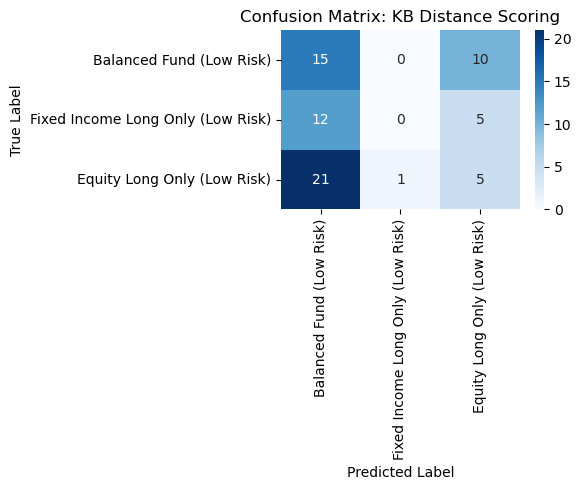

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.31      0.60      0.41        25
      Equity Long Only (Low Risk)       0.25      0.19      0.21        27
Fixed Income Long Only (Low Risk)       0.00      0.00      0.00        17

                         accuracy                           0.29        69
                        macro avg       0.19      0.26      0.21        69
                     weighted avg       0.21      0.29      0.23        69



In [239]:
#labels = ["Equity Long Only (Low Risk)", "Balanced Fund (Low Risk)", "Fixed Income Long Only (Low Risk)"]

# Create the confusion matrix
cm = confusion_matrix(df_validation["Prediction"], df_validation["KB_Distance_Predicted"], labels=strategy_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=strategy_labels, yticklabels=strategy_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: KB Distance Scoring")
plt.tight_layout()
plt.show()

print(classification_report(df_validation["Prediction"], df_validation["KB_Distance_Predicted"]))


extract_sentence_match Method: Literal word overlap (keyword counting)

In [240]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [241]:
df_validation['KB_sentences_equity_match'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_match(x, equity_kb, num_sent=5)
)
df_validation['KB_sentences_balanced_match'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_match(x, balanced_kb, num_sent=5)
)

df_validation['KB_sentences_fixed_income_match'] = df_validation['Strategy evidence'].apply(
    lambda x: extract_sentence_match(x, fixed_income_kb, num_sent=5)
)



In [242]:
predicted_strategies_match = []

for _, row in df_validation.iterrows():
    scores = {
        "Equity Long Only (Low Risk)": score_summary_against_kb(row["KB_sentences_equity_match"], equity_kb),
        "Balanced Fund (Low Risk)": score_summary_against_kb(row["KB_sentences_balanced_match"], balanced_kb),
        "Fixed Income Long Only (Low Risk)": score_summary_against_kb(row["KB_sentences_fixed_income_match"], fixed_income_kb)
    }
    # Pick the strategy with the smallest average distance
    best_strategy = min(scores, key=scores.get)
    predicted_strategies_match.append(best_strategy)

df_validation["KB_Distance_Predicted_match"] = predicted_strategies


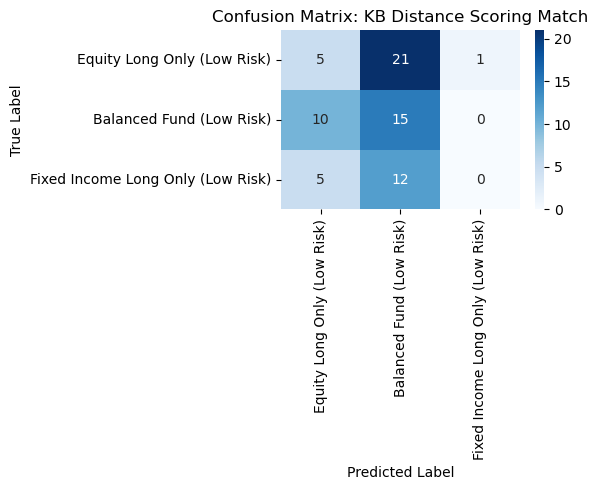

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.31      0.60      0.41        25
      Equity Long Only (Low Risk)       0.25      0.19      0.21        27
Fixed Income Long Only (Low Risk)       0.00      0.00      0.00        17

                         accuracy                           0.29        69
                        macro avg       0.19      0.26      0.21        69
                     weighted avg       0.21      0.29      0.23        69



In [243]:
labels = ["Equity Long Only (Low Risk)", "Balanced Fund (Low Risk)", "Fixed Income Long Only (Low Risk)"]

# Create the confusion matrix
cm = confusion_matrix(df_validation["Prediction"], df_validation["KB_Distance_Predicted_match"], labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: KB Distance Scoring Match")
plt.tight_layout()
plt.show()

print(classification_report(df_validation["Prediction"], df_validation["KB_Distance_Predicted_match"]))


## Deep Classifiers

/var/folders/49/1jq9sd950fg6397s7sm972380000gn/T/ipykernel_12155/1999145714.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

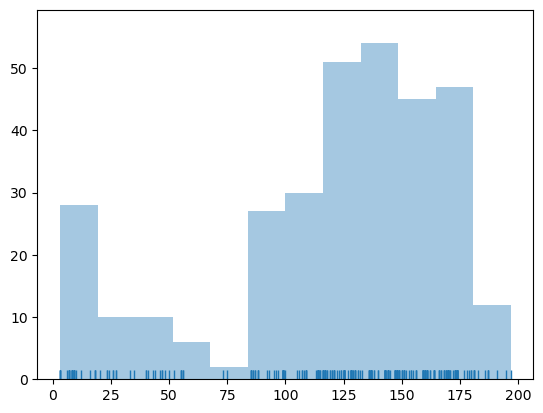

In [244]:
##Data pre-processing

# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X_training)), display_id=True)
for ii, txt in enumerate(X_training):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X_training)))

sns.distplot(sizes, kde=False, rug=True)

In [245]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [246]:
word2vec

{'UNK': array([-0.3502928 , -0.20755576, -0.36450055,  0.19277868,  0.41607082,
         0.44423142,  0.29663286,  0.42398834,  0.41053796, -0.24758041,
         0.43348384,  0.31983364,  0.42337215, -0.37089053,  0.2350652 ,
        -0.19118232, -0.3048718 ,  0.39947158,  0.324059  ,  0.30839154,
         0.4111824 , -0.44575158,  0.40810215, -0.33191687, -0.25579095,
        -0.33764023, -0.14662594, -0.16503628,  0.31643564,  0.44241697,
         0.33969757,  0.29613313,  0.34286848, -0.3536638 ,  0.41203147,
         0.3952579 ,  0.36992866,  0.3161852 , -0.34336743, -0.44905996,
        -0.31784627,  0.3270744 , -0.01795473, -0.3138615 ,  0.22212243,
        -0.2967707 ,  0.39280307, -0.42582524, -0.30228683, -0.37268868],
       dtype=float32),
 'the': array([-0.15841609, -0.28988025, -0.27643493,  0.2656779 ,  0.41931346,
         0.22118537,  0.16824496,  0.3358426 ,  0.3462171 , -0.33042032,
         0.2711359 ,  0.33692652,  0.42537615, -0.2404054 ,  0.13494143,
        -0.33

In [247]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_training)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_training)
sequences_test = keras_tokenizer.texts_to_sequences(X_testing)

In [248]:
print('Text : '+ X_training[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : Vanguard Russell 1000 Index Fund <head_breaker>

Vanguard Russell 1000 Index Fund

Investment Objective

The Fund seeks to track the performance of a benchmark index that measures the investment return of large-capitalization stocks in the United States.

Fees and Expenses

The following table describes the fees and expenses you may pay if you buy and hold Institutional Shares of the Fund.

Shareholder Fees (Fees paid directly from your investment)

Sales Charge (Load) Imposed on Purchases	None Purchase Fee	None Sales Charge (Load) Imposed on Reinvested Dividends	None Redemption Fee	None

Annual Fund Operating Expenses (Expenses that you pay each year as a percentage of the value of your investment)

Management Fees	0.07% 12b-1 Distribution Fee	None Other Expenses	0.01% Total Annual Fund Operating Expenses	0.08%

Example
Index sequences : [639, 304, 584, 72, 4, 50, 51, 639, 304, 584, 72, 4, 7, 23, 1, 4, 45, 6, 690, 1, 108, 3, 9, 774, 72, 13, 691, 1, 7, 91, 3, 155, 156, 28, 5, 1,

In [249]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [250]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 131
length of the paded first sequence : 150


In [251]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [252]:
embedding_matrix[2]

array([-2.21736133e-01, -1.70825154e-01, -4.05340314e-01,  1.33146405e-01,
        2.46305227e-01,  2.93726116e-01,  2.19323426e-01,  3.91025066e-01,
        3.50485802e-01, -2.84658879e-01,  3.30194712e-01,  3.42341572e-01,
        1.59129754e-01, -3.77475172e-01,  7.02556819e-02, -1.91105098e-01,
       -1.68605909e-01,  2.69447118e-01,  2.81530499e-01,  2.68460661e-01,
        2.58080482e-01, -3.09672445e-01,  2.38242373e-01, -4.20722902e-01,
       -1.25388592e-01, -2.06758529e-01, -8.32594037e-02, -3.04703116e-02,
        2.20843598e-01,  3.91909540e-01,  2.51557440e-01,  2.39833847e-01,
        2.22415090e-01, -2.64271230e-01,  1.81838199e-01,  2.92462289e-01,
        3.03313494e-01,  2.92349309e-01, -3.35693568e-01, -2.78094888e-01,
       -4.22659695e-01,  3.18952024e-01, -5.55061698e-02, -3.18839282e-01,
        2.16558069e-01, -4.28425670e-01,  2.26967230e-01, -3.07055891e-01,
        1.45323575e-04, -4.02235240e-01])

In [253]:
embedding_matrix.shape

(1766, 50)

In [254]:
len(word_index) + 1

1766

In [255]:
word_dimension

50

## One Dimensional Convolutional Neural Network

In [256]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return CNN

In [257]:
CNN_model = create_CNN_model()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [258]:
print(type(feature_train), feature_train.dtype, feature_train.shape)
print(type(feature_test), feature_test.dtype, feature_test.shape)
print(type(Y_training), Y_training.dtype, Y_training.shape)
print(type(Y_testing), Y_testing.dtype, Y_testing.shape)


<class 'numpy.ndarray'> float64 (322, 150)
<class 'numpy.ndarray'> float64 (70, 150)
<class 'pandas.core.series.Series'> object (322,)
<class 'pandas.core.series.Series'> object (70,)


In [259]:
unique_labels = sorted(Y_training.unique())  # Ensures consistent order
label_map = {label: idx for idx, label in enumerate(unique_labels)}

In [260]:
label_map

{'Balanced Fund (Low Risk)': 0,
 'Equity Long Only (Low Risk)': 1,
 'Fixed Income Long Only (Low Risk)': 2}

In [261]:
from tensorflow.keras.utils import to_categorical

# Step 1: map string labels to integers (if not already done)
Y_training_int = Y_training.map(label_map).values
Y_testing_int = Y_testing.map(label_map).values

# Step 2: convert to one-hot encoding
Y_training_encoded = to_categorical(Y_training_int, num_classes=3)
Y_testing_encoded = to_categorical(Y_testing_int, num_classes=3)


In [262]:
Y_training_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1

In [263]:
print(type(Y_training_encoded), Y_training_encoded.dtype, Y_training_encoded.shape)
print(type(Y_testing_encoded), Y_testing_encoded.dtype, Y_testing_encoded.shape)

<class 'numpy.ndarray'> float64 (322, 3)
<class 'numpy.ndarray'> float64 (70, 3)


In [264]:
CNN_history = CNN_model.fit(feature_train, Y_training_encoded, epochs=100, batch_size=16, validation_data=(feature_test, Y_testing_encoded))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3336 - loss: 1.1097 - val_accuracy: 0.3857 - val_loss: 1.0803
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4527 - loss: 1.0652 - val_accuracy: 0.5000 - val_loss: 1.0418
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4776 - loss: 1.0381 - val_accuracy: 0.5571 - val_loss: 1.0274
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5907 - loss: 0.9716 - val_accuracy: 0.5429 - val_loss: 0.9622
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5815 - loss: 0.9632 - val_accuracy: 0.5143 - val_loss: 0.9794
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6050 - loss: 0.8865 - val_accuracy: 0.6143 - val_loss: 0.9270
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6767 - loss: 0.7829 - val_accuracy: 0.6000 - val_loss: 0.9186
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6717 - loss: 0.8031 - val_accuracy: 0.6000 - 

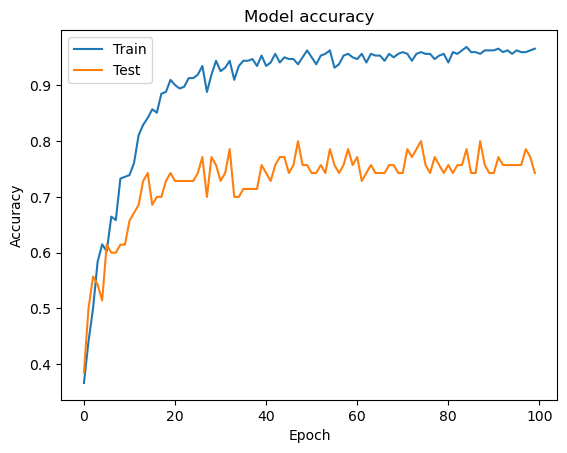

In [265]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

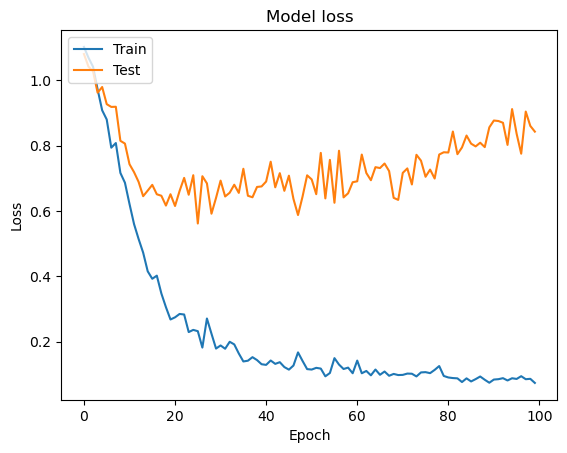

In [266]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Evaluation

In [267]:
y_pred_CNN = CNN_model.predict(feature_test)>.7

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [268]:
classes = [0, 1, 2]
y_pred_proba_CNN = CNN_model.predict(feature_test)  # shape (n_samples, 3)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [269]:
type(strategy_labels)

list

In [270]:
print(classification_report(Y_testing_encoded, y_pred_CNN, target_names=strategy_labels, output_dict=False))

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.78      0.72      0.75        25
Fixed Income Long Only (Low Risk)       0.79      0.81      0.80        27
      Equity Long Only (Low Risk)       0.83      0.56      0.67        18

                        micro avg       0.79      0.71      0.75        70
                        macro avg       0.80      0.70      0.74        70
                     weighted avg       0.80      0.71      0.75        70
                      samples avg       0.71      0.71      0.71        70



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [284]:
accuracy_score(Y_testing_encoded, y_pred_CNN)

0.7142857142857143

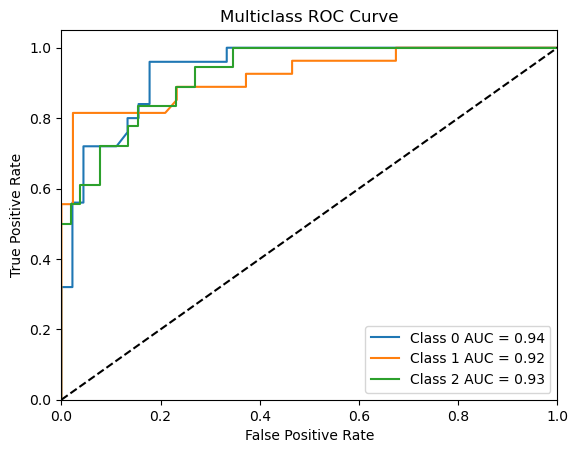

In [271]:
from sklearn.metrics import roc_curve, auc

plt.figure()
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(Y_testing_encoded[:, i], y_pred_proba_CNN[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [272]:
from sklearn.metrics import accuracy_score

# If you haven't already thresholded predictions:
y_pred_labels = np.argmax(y_pred_proba_CNN, axis=1)
y_true_labels = np.argmax(Y_testing_encoded, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.74


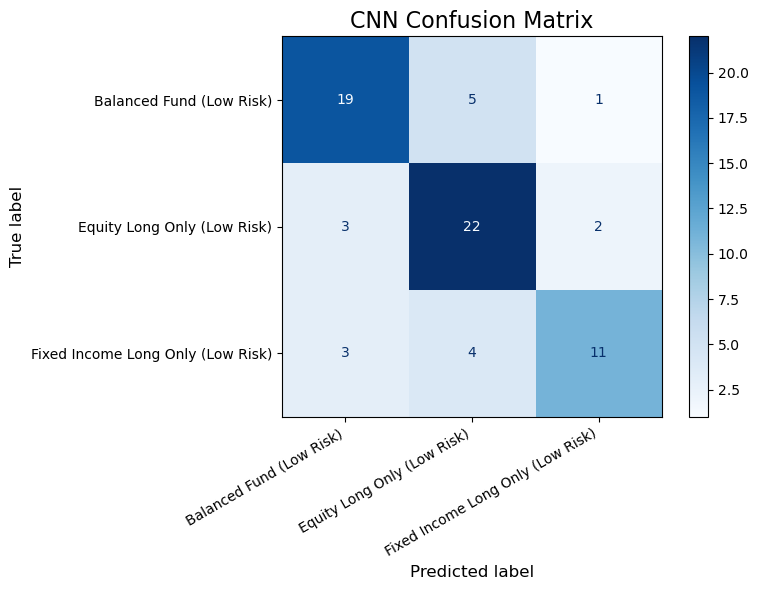

In [273]:
# Convert one-hot encoded y_test and predicted probabilities to label indices
y_true_labels_CNN = np.argmax(Y_testing_encoded, axis=1)
y_pred_labels_CNN = np.argmax(y_pred_proba_CNN, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels_CNN, y_pred_labels_CNN)

# Class names (based on your label map)
class_names = ['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)']

# Plot with larger size and clearer labels
plt.figure(figsize=(8, 6))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("CNN Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



## Recurrent Neural Networks (LSTM)

In [274]:
def create_RNN_model():
    num_classes = Y_training_encoded.shape[1]  # e.g., 3

    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix],
                      input_length=maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension, return_sequences=True)))
    RNN.add(Bidirectional(LSTM(word_dimension//2)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(num_classes, activation='softmax'))  # multiclass output

    RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return RNN


In [275]:
RNN_model = create_RNN_model()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [276]:
RNN_history = RNN_model.fit(feature_train, Y_training_encoded, epochs=200, batch_size=16, validation_data=(feature_test, Y_testing_encoded))

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3907 - loss: 1.0897 - val_accuracy: 0.5000 - val_loss: 1.0658
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4418 - loss: 1.0592 - val_accuracy: 0.5857 - val_loss: 1.0426
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4595 - loss: 1.0496 - val_accuracy: 0.5429 - val_loss: 1.0432
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4333 - loss: 1.0630 - val_accuracy: 0.6143 - val_loss: 1.0117
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4587 - loss: 1.0465 - val_accuracy: 0.5286 - val_loss: 1.0279
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.4666 - loss: 1.0223 - val_accuracy: 0.5429 - val_loss: 0.9943
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4684 - loss: 1.0191 - val_accuracy: 0.6143 - val_loss: 0.9853
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5127 - loss: 0.9932 - val_accuracy: 0.

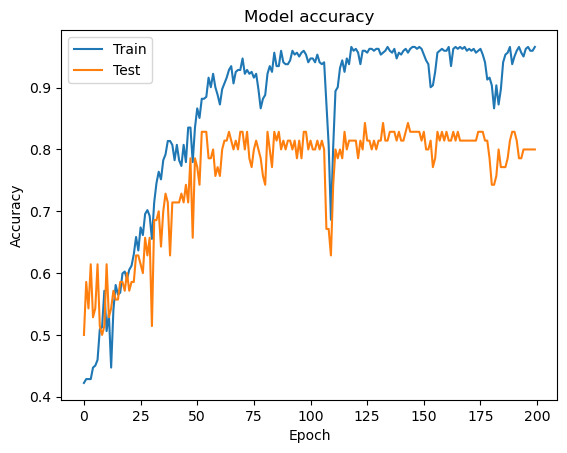

In [277]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

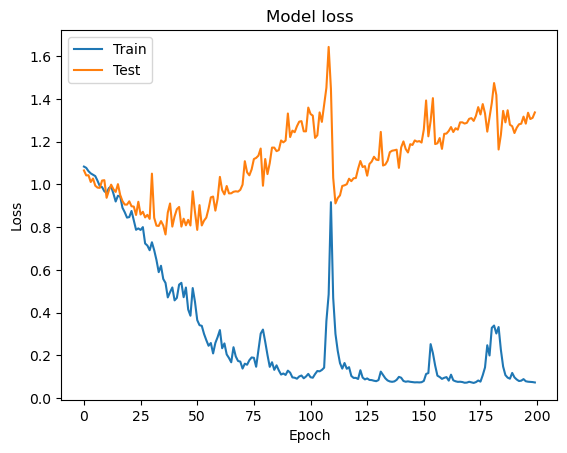

In [278]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Evaluation

In [279]:
y_pred_RNN = RNN_model.predict(feature_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/stepWARNING:tensorflow:5 out of the last 508 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x37c4d79c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


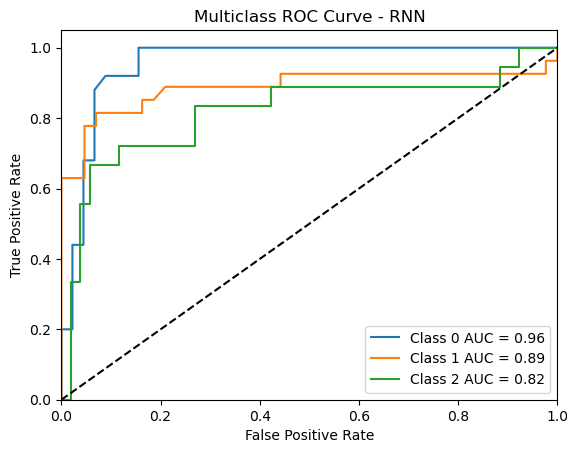

In [280]:
plt.figure()
for i in range(Y_testing_encoded.shape[1]):
    fpr, tpr, _ = roc_curve(Y_testing_encoded[:, i], y_pred_RNN[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - RNN')
plt.legend(loc='lower right')
plt.show()


In [281]:
# Convert one-hot true labels and predicted probabilities to class indices
y_true_labels_RNN = np.argmax(Y_testing_encoded, axis=1)
y_pred_labels_RNN = np.argmax(y_pred_RNN, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true_labels_RNN, y_pred_labels_RNN)
print(f"RNN Test Accuracy: {accuracy:.2f}")


RNN Test Accuracy: 0.80


In [282]:
print(classification_report(y_true_labels_RNN, y_pred_labels_RNN, target_names=strategy_labels, output_dict=False))

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.82      0.92      0.87        25
Fixed Income Long Only (Low Risk)       0.77      0.85      0.81        27
      Equity Long Only (Low Risk)       0.83      0.56      0.67        18

                         accuracy                           0.80        70
                        macro avg       0.81      0.78      0.78        70
                     weighted avg       0.80      0.80      0.79        70



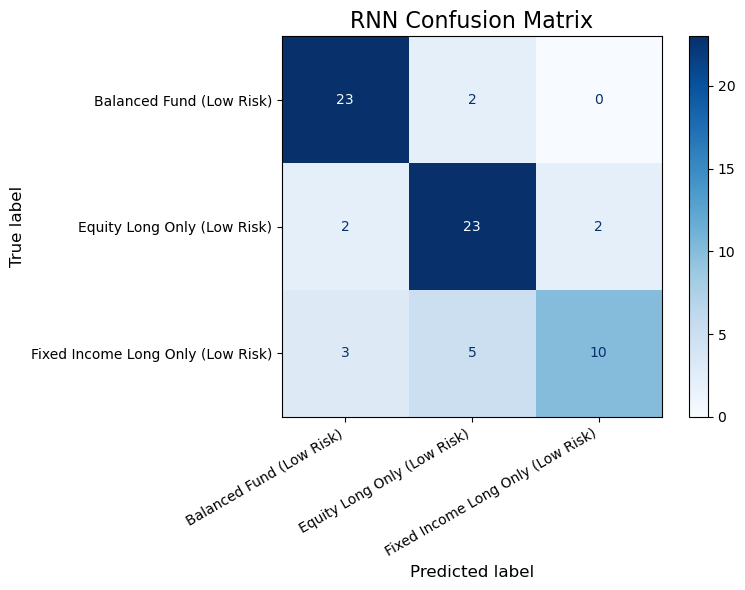

In [283]:
cm = confusion_matrix(y_true_labels_RNN, y_pred_labels_RNN)

# Class names (based on your label map)
class_names = ['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)']

# Plot with larger size and clearer labels
plt.figure(figsize=(8, 6))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("RNN Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
